# Prepare Dataset

Download dataset

In [3]:
!wget --no-check-certificate \
https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
-O /tmp/rockpaperscissors.zip

--2020-10-10 10:29:06--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  12.2MB/s    in 28s     

2020-10-10 10:29:35 (11.0 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



Extract the dataset file

In [4]:
import zipfile

local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Install split-folders library

In [5]:
pip install split-folders

Split directory (train & val)

In [6]:
import splitfolders

splitfolders.ratio(
    '/tmp/rockpaperscissors/rps-cv-images',
    output='/tmp/rockpaperscissors/output',
    seed=1337,
    ratio=(.6, .4)
)

Copying files: 2188 files [00:00, 3794.77 files/s]


# Fill in the output directory

The folder in the train directory

In [8]:
import os

os.listdir('/tmp/rockpaperscissors/output/train')

['paper', 'scissors', 'rock']

The folder in the val directory

In [9]:
os.listdir('/tmp/rockpaperscissors/output/val')

['paper', 'scissors', 'rock']

Defines a directory

In [10]:
import os.path

base_dir = '/tmp/rockpaperscissors/output'
train_dir = os.path.join(base_dir, 'train')
train_paper_dir = os.path.join(train_dir, 'paper')
train_rock_dir = os.path.join(train_dir, 'rock')
train_scissors_dir = os.path.join(train_dir, 'scissors')

validation_dir = os.path.join(base_dir, 'val')
val_paper_dir = os.path.join(validation_dir, 'paper')
val_rock_dir = os.path.join(validation_dir, 'rock')
val_scissors_dir = os.path.join(validation_dir, 'scissors')

The total images in each folder

In [11]:
print('Total training paper image:', len(os.listdir(train_paper_dir)))
print('Total training rock image:', len(os.listdir(train_rock_dir)))
print('Total training scissors image:', len(os.listdir(train_scissors_dir)))
print('=================================== ')
print('Total validation paper image:', len(os.listdir(val_paper_dir)))
print('Total validation rock image:', len(os.listdir(val_rock_dir)))
print('Total validation scissors image:', len(os.listdir(val_scissors_dir)))

Total training paper image: 427
Total training rock image: 435
Total training scissors image: 450
Total validation paper image: 285
Total validation rock image: 291
Total validation scissors image: 300


# Create a CNN architecture

Import library tensorflow

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

CNN architectural settings

In [13]:
model = tf.keras.models.Sequential([                 
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

Compile CNN

In [14]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

# Image data augmentation

create an ImageDataGenerator object for training and testing data

In [15]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest',
    validation_split=0.5
)

Prepare training data that will be studied by the model

In [16]:
# for data training
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'
)

# for data validation
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=73,
    class_mode='sparse'
)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


# Training model

create callback class

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.99):
      print("\n Accuracy has reached 99%, the training process is stopped!")
      self.model.stop_training = True

callbacks = myCallback()

proses training

In [18]:
training_process = model.fit(
    train_generator,
    steps_per_epoch=41,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=12,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/20
41/41 - 15s - loss: 1.0935 - accuracy: 0.3803 - val_loss: 1.0054 - val_accuracy: 0.5308
Epoch 2/20
41/41 - 15s - loss: 0.9353 - accuracy: 0.5282 - val_loss: 0.7939 - val_accuracy: 0.6324
Epoch 3/20
41/41 - 15s - loss: 0.6071 - accuracy: 0.7660 - val_loss: 0.5487 - val_accuracy: 0.7557
Epoch 4/20
41/41 - 15s - loss: 0.4663 - accuracy: 0.8201 - val_loss: 0.4961 - val_accuracy: 0.8151
Epoch 5/20
41/41 - 15s - loss: 0.4301 - accuracy: 0.8422 - val_loss: 0.4227 - val_accuracy: 0.8436
Epoch 6/20
41/41 - 15s - loss: 0.3608 - accuracy: 0.8811 - val_loss: 0.3211 - val_accuracy: 0.8870
Epoch 7/20
41/41 - 15s - loss: 0.2917 - accuracy: 0.8971 - val_loss: 0.2247 - val_accuracy: 0.9338
Epoch 8/20
41/41 - 15s - loss: 0.2702 - accuracy: 0.9040 - val_loss: 0.2021 - val_accuracy: 0.9395
Epoch 9/20
41/41 - 15s - loss: 0.1939 - accuracy: 0.9375 - val_loss: 0.1358 - val_accuracy: 0.9566
Epoch 10/20
41/41 - 15s - loss: 0.1952 - accuracy: 0.9329 - val_loss: 0.1928 - val_accuracy: 0.9326
Epoch 11/

Visualization of the training process

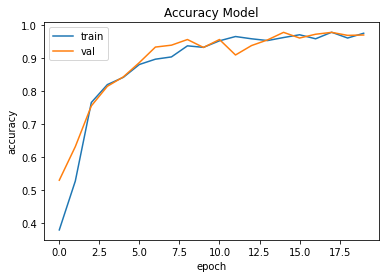

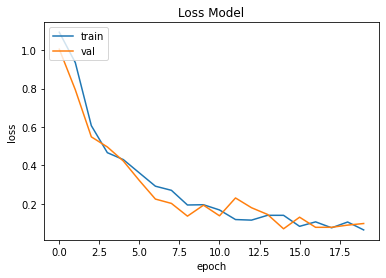

In [19]:
import matplotlib.pyplot as plt

# history visualization accuracy model
plt.plot(training_process.history['accuracy'])
plt.plot(training_process.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# history visualization loss model
plt.plot(training_process.history['loss'])
plt.plot(training_process.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing 

Saving batu.jpeg to batu.jpeg
batu.jpeg is :  ROCK image


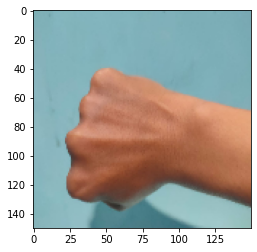

In [20]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  predictions = model.predict(images, batch_size=32)
  max_index = np.argmax(predictions[-1])
  classes = ('PAPER', 'ROCK', 'SCISSORS')
  prediction = classes[max_index]

  print(fn, "is : ", prediction, "image")

Nama : Arif Nur Rohman